### data preparation and issue resolution:
#### 1. pickup and drop off times might not make any sense - e.g. a trip where no time has elapsed but was 10 miles. RESOLVE: This issue may be resolved by ignoring data in the model where the dropoff time is equal to the pickup time.
#### 2. Pickup and dropoff times are given as a date and a military time. However, it would better if we ignored the date and just analyzed the time (and assume the day of the month is not an important feature...i.e. why would March 4th be more important than March 24th?). RESOLVE: Clean data by replacing pickup and drop off columns by the following two columns: a. total elapsed ride time in minutes b. pickup time of day by the hour. This is to see if there is a time of day relationship, and it is probably unnecessary to distinguish data by _the minute and second_.
#### 3. remove redundancies: including the total amount in the model is unnecessary since it is just the sum of the fare amount + taxes + tip
#### 4. incorporate time-of-year feature: It might be a good idea to establish how tip amounts depend on how cold it is outside - perhaps if it is November and below freezing out, riders may be more inclined to tip less since they are in a rush to get warm. RESOLVE: randomly mix data from March, June, and November tables and create an additional categorical feature that distinguishes the month
#### 5. We don't need to use all $\mathcal{O}(\text{10}^7)$ trips to build a model, so we will just fetch a tiny fraction of it - perhaps $\mathcal{O}(\text{10}^4)$ instead
#### 6. include only credit card data, since tip data is not recorded for cash transactions

# Load Data

In [260]:
import pandas as pd
import random
import time

""" The csv files are way too large to use for training, but not quite large enough to go to the cloud. 
    So here, we simply read a small random sample from the files for March, June, and November into separate dataframes.
    These samples will each have a random size. The sample has to be random, because we can't just select the 
    first few rows because the data is ordered by pick up date & time, which would add model bias."""

""" 'sample_probability' indicates the probability that a particular row in the csv file will be sampled"""
sample_probability = 0.0005

MARCH_PATH = "yellow_tripdata_2017-03.csv"
JUNE_PATH = "yellow_tripdata_2017-06.csv"
NOVEMBER_PATH = "yellow_tripdata_2017-11.csv"

start = time.time()

march_df = pd.read_csv(MARCH_PATH, skiprows=lambda i: i>0 and random.random()>sample_probability)
june_df = pd.read_csv(JUNE_PATH, skiprows=lambda i: i>0 and random.random()>sample_probability)
november_df = pd.read_csv(NOVEMBER_PATH, skiprows=lambda i: i>0 and random.random()>sample_probability)

end = time.time()
print("read time: {} seconds".format(end - start))

read time: 16.25940203666687 seconds


# Prepare and Clean Data 

In [261]:
""" add a month feature to each dataframe and merge the dataframes into one called 'total_sample' """
march_df['month'] = 'March'
june_df['month'] = 'June'
november_df['month'] = 'November'

months = [march_df, june_df, november_df]
total_sample = pd.concat(months, ignore_index=True)

""" add a trip duration feature"""
total_sample['tpep_pickup_datetime'] = pd.to_datetime(total_sample['tpep_pickup_datetime'])
total_sample['tpep_dropoff_datetime'] = pd.to_datetime(total_sample['tpep_dropoff_datetime'])
total_sample['trip duration'] = total_sample['tpep_dropoff_datetime'] - total_sample['tpep_pickup_datetime']

"""add an hour of the day feature"""
total_sample['hour of day'] = total_sample['tpep_pickup_datetime'].dt.hour

"""remove data where trip duration = 0, if any, since that wouldn't make sense"""
total_sample = total_sample[total_sample['trip duration'] != 0 ]

"""remove data where payment type is not a credit card"""
total_sample = total_sample[total_sample['payment_type'] == 1]

"""finally, convert trip duration to an integer hour, so estimator does not complain about datetime types"""
total_sample['trip duration'] = total_sample['trip duration'].dt.total_seconds().div(60).astype(int)
total_sample

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,trip duration,hour of day
0,2,2017-03-10 14:20:45,2017-03-10 14:26:56,1,1.60,1,N,68,249,1,7.0,0.0,0.5,1.00,0.0,0.3,8.80,March,6,14
1,1,2017-03-10 14:30:39,2017-03-10 14:57:11,3,8.30,1,N,141,97,1,27.5,0.0,0.5,7.05,0.0,0.3,35.35,March,26,14
2,2,2017-03-10 14:31:37,2017-03-10 14:39:26,5,1.39,1,N,90,170,1,7.5,0.0,0.5,1.66,0.0,0.3,9.96,March,7,14
3,1,2017-03-10 14:44:11,2017-03-10 14:52:40,1,1.00,1,N,144,79,1,7.0,0.0,0.5,1.00,0.0,0.3,8.80,March,8,14
4,2,2017-03-10 14:54:17,2017-03-10 15:11:38,1,1.60,1,N,186,162,1,11.5,0.0,0.5,2.46,0.0,0.3,14.76,March,17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14553,1,2017-11-30 22:13:45,2017-11-30 22:19:13,4,0.80,1,N,237,142,1,6.0,0.5,0.5,1.45,0.0,0.3,8.75,November,5,22
14554,2,2017-11-30 22:51:17,2017-11-30 22:58:06,1,3.09,1,N,132,10,1,10.5,0.5,0.5,2.95,0.0,0.3,14.75,November,6,22
14556,2,2017-11-30 23:06:28,2017-11-30 23:47:18,1,7.57,1,N,230,65,1,30.0,0.5,0.5,6.26,0.0,0.3,37.56,November,40,23
14557,1,2017-11-30 23:55:03,2017-12-01 00:03:42,1,1.30,1,N,234,100,1,7.5,0.5,0.5,1.20,0.0,0.3,10.00,November,8,23


# Finalize data set

In [278]:
""" To send data for training, redundant features are removed"""

X = total_sample.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime','total_amount','tip_amount','payment_type'])
y = total_sample['tip_amount']

## preliminary data assessment:
#### A common sense initial guess is to assume the tip amount should depend linearly on fare amount, since many people tip at 10-20%. We see that this assessment is partially true in the plot below. However, it does not explain why some people do not tip at all or the vertical line at ~50 dollar fare. So it is probably best to use a non-linear model. We will go with a random forest
#### A regression forest is the best choice for this data for a few reasons:
#### a. There is no notion of "distance" or scale for the features in this data, e.g. one can't reasonable put "November" and "5 miles" in the same vector space.
#### b. There is a mix of numerical and categorical variables, so using a forest is easy because we can just hot-encode the categorical variables in one preprocessing step.
#### c. Forests extend upon decision trees by reducing model variance - decision trees are just too prone to overfitting the sample - unless we use an _enormous_ set of training data

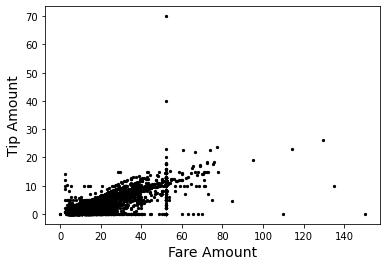

In [264]:
plt.scatter(X['fare_amount'], y,color='k',s=5)
plt.xlabel('Fare Amount',fontsize=14)
plt.ylabel('Tip Amount',fontsize=14)
plt.xlim(0,60)
plt.ylim(0,30)
plt.show()

# Import machine learning tools

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import numpy as np

# Model Build

## hyperparameters:

In [280]:
forest_parameters = {'min_samples_leaf': 10, 'n_estimators':100, 'max_features': 'auto'}
TEST_SAMPLE_SIZE = 0.25
GROUPS = 5
FEATURE_NUM = len(X.columns)

## create pipeline option 1: 
### a. hot encode categorical variables 
### b. train forest and validate with hold out method

In [149]:
"""define objects in pipeline"""
forest_regressor = RandomForestRegressor(**forest_parameters)

column_trans = make_column_transformer((OneHotEncoder(),['store_and_fwd_flag','month']),remainder='passthrough')

"""build pipeline"""
pipe = make_pipeline(column_trans, forest_regressor)

## train and validate model : hold-out method

In [150]:
from sklearn import metrics

"""hold out a portion of the data for testing"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SAMPLE_SIZE, random_state=0)

"""train model"""
pipe.fit(X_train, y_train)

"""test model and calculate mean squared error"""
y_pred = pipe.predict(X_test)

rms_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMS Error:', rms_error)

RMS Error: 1.6757205934330113


## create pipeline option 2: 
### a. hot encode 
### b. train forest and sweep hyperparameters in k-fold cross validation

In [281]:
"""define objects in pipeline"""

forest_regressor = RandomForestRegressor(**forest_parameters)

param_grid = {
    'max_features': np.linspace(1, FEATURE_NUM, num=FEATURE_NUM).astype(int),
    #'min_samples_leaf': np.linspace(1,100,num=100).astype(int),
}

param_search = GridSearchCV(forest_regressor, param_grid, cv=GROUPS, n_jobs=-1, scoring='neg_mean_squared_error')

column_trans = make_column_transformer((OneHotEncoder(),['store_and_fwd_flag','month']),remainder='passthrough')

"""build pipeline"""
pipe = make_pipeline(column_trans, param_search)

## train and validate model: k-fold cross validation 

In [286]:
"""hold out a portion of the data for testing"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SAMPLE_SIZE, random_state=0)

"""train a model for each value in a set of hyperparameters. At each value, perform k-fold cross validation
   to obtain a score, averaged over k groups. Model with best score will be saved to be used for testing."""

start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
print('parameter sweep + cross validation took {} seconds'.format(end-start))

parameter sweep + cross validation took 6.070387125015259 seconds


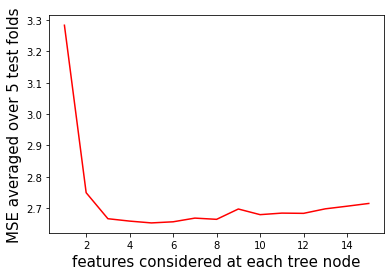

In [290]:
"""plot score over all values in parameter sweep"""
import matplotlib.pyplot as plt
plt.plot(np.linspace(1, FEATURE_NUM, num=FEATURE_NUM), abs(param_search.cv_results_['mean_test_score']),color='r')
plt.ylabel('MSE averaged over {} test folds'.format(GROUPS),fontsize=15)
plt.xlabel('features considered at each tree node', fontsize=15)
plt.show()

In [288]:
"""test best model on test set and calculate the predicted tip amounts"""
y_pred = pipe.predict(X_test)
rms_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMS Error: ${}'.format(rms_error))

RMS Error: $1.2368956179078885


# Analysis of Results

Text(0.5, 1.0, 'Feature Importance')

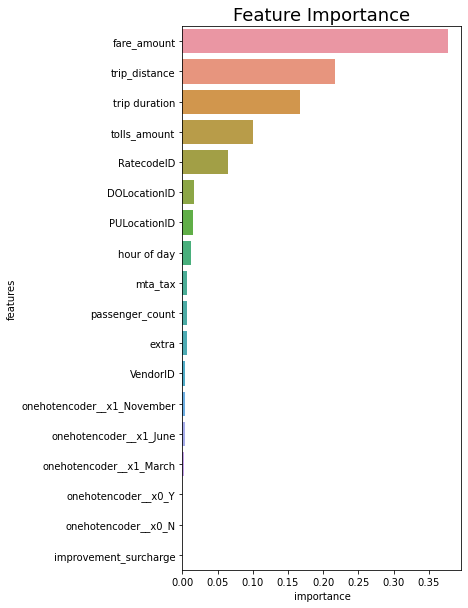

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt

variable_importances = param_search.best_estimator_.feature_importances_
variable_names = column_trans.get_feature_names()

importance_df = pd.DataFrame()
importance_df['importance'] = variable_importances
importance_df['features'] = variable_names

plt.figure(figsize=(5,10))
sns.barplot(x='importance',
            y='features', 
            data=importance_df.sort_values('importance',ascending = False),orient='h')
plt.title('Feature Importance',fontsize=18)


# Discussion
### As expected, the total fare amount is the most important predictor of tip amount. The most important predictors: fare amount, trip distance/duration, and toll amount all make intuitive sense. What is interesting though is that the ratecodeID bears significant weight as well. Upon further investigation, in the table below, we see that for ratecodeID = 2 (trips to JFK airport), there is a special fare amount of exactly 52 dollars. This special fare amount probably corresponds to the vertical line we saw earlier in the Fare vs. Tip plot. 
### For whatever reason, the fact that the taxi service charges a special rate for airport trips affects the rider's decision on how to tip. Whereas a linear model would predict a single tip value for trips of 52 dollars, the forest has allowed us to see that the tip value for airport trips is much more variable.
### Another result is that the time of year (March, June, November) is not that important, so next time we can ignore that feature
### Lastly, note that there is probably some cross-correlation between duration, distance, and fare amount since one could argue that all are roughly proportional to one another. However, it is best to keep all three features because there may be situations where there was a bad driver who got lost or some other caveat

In [296]:
total_sample.groupby(['RatecodeID']).mean()

,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip duration,hour of day
RatecodeID,,,,,,,,,,,,,,,
1,1.561578,1.632087,2.681323,163.979543,162.588681,1.0,12.287902,0.325597,0.499792,2.499946,0.244416,0.299938,16.165209,15.916511,13.679751
2,1.565022,1.672646,17.823004,146.600897,142.847534,1.0,52.000000,0.786996,0.500000,10.495202,4.222735,0.300000,68.313677,48.860987,14.049327
3,1.473684,1.368421,18.280000,183.631579,42.631579,1.0,71.842105,0.157895,0.000000,14.617895,14.789474,0.300000,101.707368,44.210526,12.157895
4,2.000000,1.000000,20.258000,120.600000,265.000000,1.0,80.900000,0.400000,0.500000,15.556000,3.652000,0.300000,101.308000,49.400000,12.600000
5,1.606061,1.515152,2.661818,176.666667,197.181818,1.0,57.224242,0.000000,0.136364,7.835455,2.289091,0.290909,67.776061,7.575758,12.393939


# Improvements

### 1. A more extensive hyperparameter search
### 2. Features that incorporate behavioral aspects such as driver rating, etc. since the tip amount likely depends a lot on how friendly the driver is
### 3. More efficient data pipeline

# API use

### This model can be wrapped in some Python module that sofware developers at the ride sharing company can import into their code when designing their app. Upon a function call, the predicted tip amount for inputted raw trip data should be returned.